This Notebook contains the analysis of the question :

**What is the ideal time frame between a book's publication and its film adaptation?**

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import re
import ast
import networkx as nx
import statsmodels.formula.api as smf

# Part I

In [15]:
df2 = pd.read_csv("./data/book_adaptation.csv")
df2.columns

Index(['movie_title', 'movie_release', 'movie_revenue', 'movie_runtime',
       'movie_languages', 'movie_countries', 'movie_genres', 'imdb_rating',
       'imdb_total_votes', 'movie_budget', 'book_title', 'book_author',
       'book_release', 'book_country', 'book_part_of_series', 'literary_work',
       'written_work', 'comic_book_seris', 'book_series', 'manga_series',
       'book_fiction', 'book_non_fiction', 'book_children', 'book_historical',
       'book_drama', 'book_anime', 'book_fantasy', 'book_science_fiction',
       'book_horror', 'book_thriller', 'book_detective', 'book_satire',
       'book_comedy', 'book_won_price', 'book_pages', 'book_rating',
       'book_total_ratings', 'movie_is_adaptation'],
      dtype='object')

In [16]:
df = df2[["movie_title", "movie_release", "book_release", "movie_is_adaptation", 'imdb_rating','book_part_of_series',
       'written_work', 'comic_book_seris', 'book_series', 'manga_series']]
df = df[df["book_release"].notnull()]
df = df.drop(columns='movie_is_adaptation', axis=1).copy(deep=True)
df = df[df['movie_release'].notnull()].copy(deep=True)
df

,movie_title,movie_release,book_release,imdb_rating,book_part_of_series,written_work,comic_book_seris,book_series,manga_series
43,Mysterious Island,1982.0,1959.0,5.4,1.0,0.0,0.0,0.0,0.0
44,Mysterious Island,1982.0,1957.0,5.4,1.0,1.0,0.0,0.0,0.0
96,The Thirteen Chairs,1969.0,1928.0,5.8,0.0,0.0,0.0,0.0,0.0
132,The Great Santini,1979.0,1976.0,7.2,0.0,0.0,0.0,0.0,0.0
135,Carmen,2003.0,1845.0,6.1,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
81913,Norwegian Wood,2010.0,1987.0,6.3,0.0,1.0,0.0,0.0,0.0
81937,The Four Feathers,1939.0,1902.0,7.4,0.0,0.0,0.0,0.0,0.0
81944,How to Eat Fried Worms,2006.0,1973.0,5.3,1.0,0.0,0.0,0.0,0.0
81961,Sherlock Holmes and the Voice of Terror,1942.0,1917.0,6.4,1.0,0.0,0.0,0.0,0.0


In [17]:
df[["book_release","movie_release", 'book_part_of_series',
       'written_work', 'comic_book_seris', 'book_series', 'manga_series']] = df[["book_release", "movie_release",'book_part_of_series',
       'written_work', 'comic_book_seris', 'book_series', 'manga_series']].astype(int);

In [18]:
df["time_frame"] = (df['movie_release']-df['book_release']).astype(int)

In [19]:
df = df.query('time_frame > 0')
df

,movie_title,movie_release,book_release,imdb_rating,book_part_of_series,written_work,comic_book_seris,book_series,manga_series,time_frame
43,Mysterious Island,1982,1959,5.4,1,0,0,0,0,23
44,Mysterious Island,1982,1957,5.4,1,1,0,0,0,25
96,The Thirteen Chairs,1969,1928,5.8,0,0,0,0,0,41
132,The Great Santini,1979,1976,7.2,0,0,0,0,0,3
135,Carmen,2003,1845,6.1,0,0,0,0,0,158
...,...,...,...,...,...,...,...,...,...,...
81913,Norwegian Wood,2010,1987,6.3,0,1,0,0,0,23
81937,The Four Feathers,1939,1902,7.4,0,0,0,0,0,37
81944,How to Eat Fried Worms,2006,1973,5.3,1,0,0,0,0,33
81961,Sherlock Holmes and the Voice of Terror,1942,1917,6.4,1,0,0,0,0,25


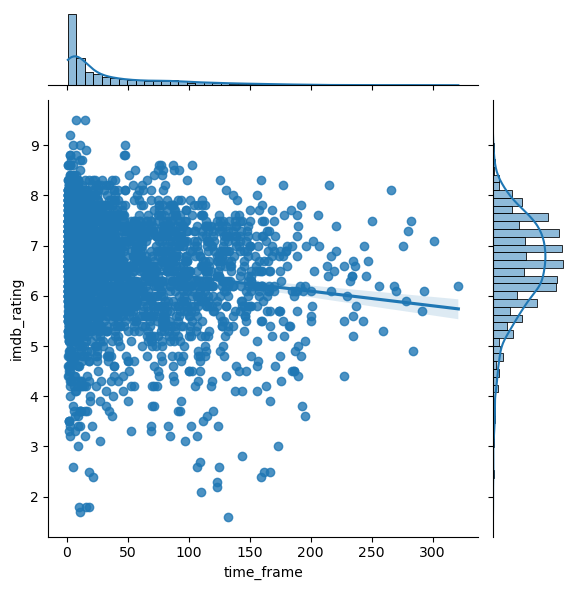

In [20]:
sns.jointplot(data=df,x=df['time_frame'], y=df['imdb_rating'], kind="reg", );



# Part II :

Exact Matching

In [21]:
time_frame_criteria = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

In [48]:
def get_mean_rating(time_frame_criteria, df):
    control = df.query('time_frame <='+str(time_frame_criteria))
    treated = df.query('time_frame >'+str(time_frame_criteria))

    G = nx.Graph()

    for control_id, control_row in control.iterrows():
        for treatment_id, treatment_row in treated.iterrows():
            serie = control_row['book_part_of_series'] == treatment_row['book_part_of_series']
            written_work = control_row['written_work'] == treatment_row['written_work']
            comic_book_seris = control_row['comic_book_seris'] == treatment_row['comic_book_seris']
            book_series = control_row['book_series'] == treatment_row['book_series']
            manga_series = control_row['manga_series'] == treatment_row['manga_series']
            same_era_book_release = abs(control_row['book_release']-treatment_row['book_release']) <= 5
            if (serie and written_work and comic_book_seris and book_series and manga_series and same_era_book_release):
                G.add_weighted_edges_from([(control_id, treatment_id, 1)])

    matching = nx.max_weight_matching(G)
    matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
    matched_array = np.array(matched)
    matched_array
    matching_df = df.loc[matched_array]

    return matching_df

In [76]:
matching_df = get_mean_rating(2.1, df)

In [77]:
matching_df

,movie_title,movie_release,book_release,imdb_rating,book_part_of_series,written_work,comic_book_seris,book_series,manga_series,time_frame
29633,The Seven-Per-Cent Solution,1976,1974,6.6,0,1,0,0,0,2
2300,Man on Fire,1987,1980,5.8,0,0,0,0,0,7
40220,The Mermaid Chair,2006,2005,4.8,0,1,0,0,0,1
24881,Oliver's Story,1978,1977,4.6,0,0,0,0,0,1
23279,Double Indemnity,1944,1943,8.3,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
4820,Capitaine Conan,1996,1934,7.2,0,1,0,0,0,62
5829,The Big Man,1990,1986,5.7,0,0,0,0,0,4
507,Unforgivable,2011,2009,5.8,0,0,0,0,0,2
77401,No Smoking...!,2007,1978,7.3,0,0,0,0,0,29


In [78]:
matching_df["written_work"].sum()

284

Linear Regression (imdb_rating ~ time_frame)

In [80]:
lin_reg_model = smf.ols(formula='imdb_rating ~ time_frame', data=matching_df)
lin_reg_fit = lin_reg_model.fit()
print(lin_reg_fit.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:            imdb_rating   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.300
Date:                Fri, 08 Dec 2023   Prob (F-statistic):             0.0696
Time:                        14:52:18   Log-Likelihood:                -1131.0
No. Observations:                 848   AIC:                             2266.
Df Residuals:                     846   BIC:                             2276.
Df Model:                           1                                         
Covariance Type:            nonrobust  

In [179]:
mean_rating = np.zeros([len(time_frame_criteria), 3])
for i in time_frame_criteria:
    mean_rating[int(i/5-1),0] = i
    [mean_treated, mean_controlled] = get_mean_rating(i, df)
    mean_rating[int(i/5-1),1] = mean_treated
    mean_rating[int(i/5-1),2] = mean_controlled